In [1]:
from os import sys
# Path to workspace
#sys.path.insert(0, '/workspace/3d-shapes-embeddings/contrib/sharp_features/')
sys.path.insert(0, '/workspace/dense-self-supervised-representation-learning-for-3D-shapes/')

import h5py
import torch
import numpy as np
from tqdm import tqdm
import k3d

In [2]:
import neptune.new as neptune
from workspace.utils.train_loop import *

params = {
    'name': 'meshcnn global pretrained',
    'dataset': 'abc',
    'batch_size': 10,
    'tau': 0.07,
    'n_output': 512,
    'result_dim': 128,
    'hidden_dim': 256,
    'total_epochs': 100,
    'lr': 5e-4,
    'weight_decay': 1e-5,
    'save_every': 100,
    'weights_root': '../weights/'
}

# tags
tags = ['abc']

logger = neptune.init(
    project="igor3661/crossmodal",
    name=params['name'],
    tags=tags,
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcG'\
              'lfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiN'\
              'zcxMGNkOS04ZjU3LTRmNDMtOWFjMS1kNDNkZDZlNDI4YWYifQ==',
)  # your credentials


logger['parameters'] = params

device = 'cuda:1'

/opt/conda/lib/python3.8/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")
/opt/conda/lib/python3.8/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


https://app.neptune.ai/igor3661/crossmodal/e/CROSS-5
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [3]:
from torch.utils.data import DataLoader
from workspace.crossmodal.data.datasets import *
from workspace.datasets.transforms import *
from workspace.crossmodal.utils.collates import collate_clouds, collate_meshcnn, multicollate

In [4]:
train_data = DoubleDataset(
    data_path='abc_train.hdf5',
    modality=Modality.MESHCNN,
    meshcnn_opt = AttrDict({
        'normalize': True,
        'num_aug': 1,
        'scale_verts': True,
        'slide_verts': 0.2,
        'flip_edges': 0.2,
        'is_train': True,
        'ninput_edges': 700
    })
)

val_data = DoubleDataset(
    data_path='abc_test.hdf5',
    modality=Modality.MESHCNN,
    meshcnn_opt = AttrDict({
        'normalize': True,
        'num_aug': 1,
        'scale_verts': True,
        'slide_verts': 0.2,
        'flip_edges': 0.2,
        'is_train': True,
        'ninput_edges': 700
    })
)

#CrossmodalDataset.__len__ = lambda x:2

collate = lambda data:multicollate(
    data,
    lambda x: collate_meshcnn(x, device=device),
    lambda x: collate_meshcnn(x, device=device)
)

train_loader = DataLoader(train_data, collate_fn=collate, batch_size=params['batch_size'])
val_loader = DataLoader(val_data, collate_fn=collate, batch_size=params['batch_size'])

In [5]:
class Model(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.backbone = model
        self.global_pool = torch.nn.AdaptiveAvgPool1d(1)
        
        self.head = torch.nn.Sequential(
            torch.nn.Linear(64, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
        )
        
    def forward(self, fe, meshes):
        fe = self.backbone(fe, meshes)
        global_fe = self.global_pool(fe).squeeze()
        
        return self.head(global_fe)

In [6]:
from workspace.crossmodal.models.meshcnn.networks import *

backbone = MeshEncoderDecoder(
    pools=[0, 700, 600, 500, 400, 200],
    down_convs=[5, 64, 128, 256, 512, 1024],
    up_convs=[1024, 1024, 512, 256, 128, 64],
    blocks=1
)

model = Model(backbone).to(device)

In [7]:
from workspace.crossmodal.utils.losses import *

def forward( 
    model,
    batch, # raw data from dataloader
    logger, # neptune run
    mode # 'train'/'val'
): # -> loss

    mesh1, fe1, mesh2, fe2 = batch[0]['mesh'], batch[0]['edge_features'],\
                             batch[1]['mesh'], batch[1]['edge_features']
        
    out1 = model(fe1, mesh1)
    out2 = model(fe2, mesh2)
    

    
    mesh_loss = contrastive_loss(out1, out2, params)
    
    
    return {
        'loss': mesh_loss
    }

In [8]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=params['lr'],
    weight_decay=params['weight_decay']
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader) * params['total_epochs'])

In [9]:
train_model(model, params, logger, train_loader, val_loader, optimizer, scheduler, forward)

  9%|▉         | 9/100 [00:23<04:00,  2.64s/it, Epoch=6, Loss=0.91] 


KeyboardInterrupt: 

In [11]:
batch = next(iter(val_loader))
with torch.no_grad():
    fm1 = model(batch[0]['edge_features'], batch[0]['mesh']).detach().cpu()
    fm2 = model(batch[1]['edge_features'], batch[1]['mesh']).detach().cpu()

In [12]:
fm1 = F.normalize(fm1, dim=-1)
fm2 = F.normalize(fm2, dim=-1)

res = fm1 @ fm2.T

print(res)

tensor([[ 0.9963,  0.7120, -0.6974,  0.9419, -0.5216, -0.2528, -0.5803, -0.7098,
         -0.6108, -0.5647],
        [ 0.6500,  0.8546, -0.7432,  0.7219, -0.0163,  0.4114, -0.1007, -0.4208,
         -0.8209, -0.7952],
        [-0.7186, -0.6546,  0.9283, -0.6721,  0.4906, -0.0133,  0.6639,  0.8541,
          0.5624,  0.4931],
        [ 0.9062,  0.8630, -0.7153,  0.9314, -0.2564, -0.0197, -0.3482, -0.5762,
         -0.7683, -0.7065],
        [-0.5343, -0.0491,  0.2375, -0.2956,  0.9054,  0.5726,  0.8644,  0.6996,
         -0.1615, -0.1391],
        [-0.3018,  0.2360, -0.1921, -0.1423,  0.5964,  0.9015,  0.4975,  0.2663,
         -0.4101, -0.4065],
        [-0.6082, -0.2037,  0.4367, -0.4049,  0.9237,  0.5463,  0.9871,  0.8598,
         -0.0627, -0.0703],
        [-0.7618, -0.3634,  0.5405, -0.6036,  0.8163,  0.4575,  0.8084,  0.8051,
          0.2125,  0.2233],
        [-0.6298, -0.7992,  0.6326, -0.7753, -0.1881, -0.3036, -0.1107,  0.2369,
          0.8786,  0.7714],
        [-0.5489, -

<AxesSubplot:>

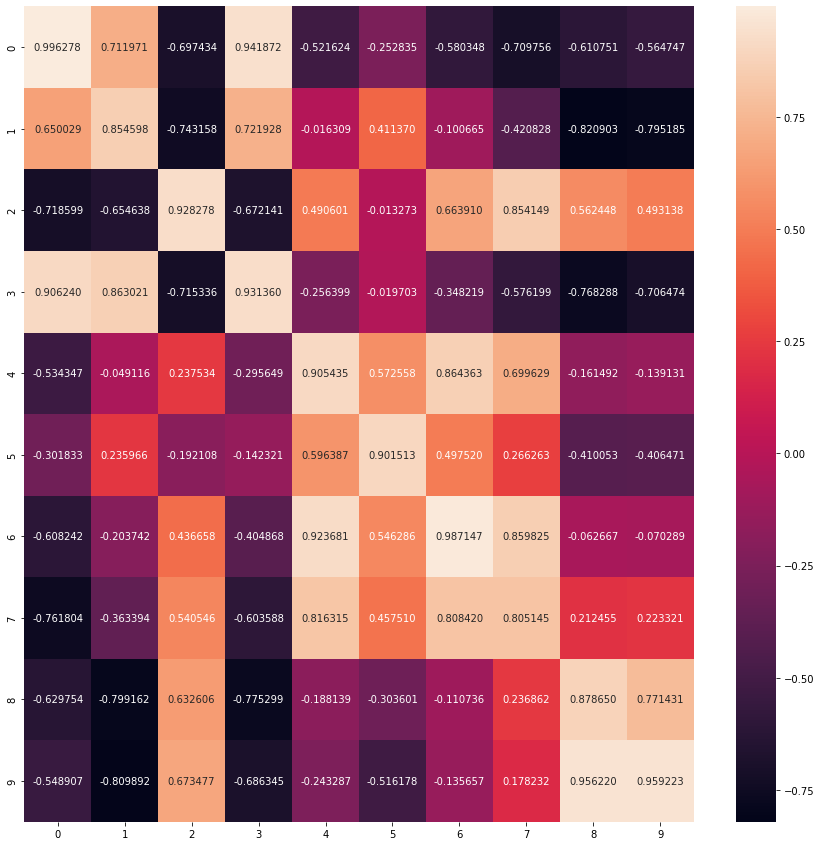

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 15))
sns.heatmap(res, annot=True, fmt="f", )

In [ ]:
res = model.backbone(batch['edge_features'], batch['mesh'])
res.shape

In [ ]:
model.global_pool(res).shape

In [ ]:
model(batch['edge_features'], batch['mesh'])